# Preliminary tests for OTGAN
Based on :

[1] Tim Salimans, Han Zhang, Alec Radford, and Dimitris Metaxas. **Improving GANs using optimal
transport.** In ICLR, 2018.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from datetime import datetime

import torch
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import tqdm

In [2]:
# path = "C:/Users/Philo/Documents/3A -- ENSAE/Optimal transport/OTGAN"
# os.chdir(path)

### Model parameters and hyperparameters

In [3]:
args={}
kwargs={}
args['batch_size']=10
args['val_batch_size']=10
args['epochs']=10  

# Use the same value as author's for CIFAR for Adam LR and beta values :
args['lr']=3*1e-4
args['beta1']= 0.5
args['beta2']= 0.999


args['seed']=1 #random seed
args['cuda']=True if torch.cuda.is_available() else False
device = "cuda" if args['cuda']==True else "cpu"


args["n_gen"] = 3 # number of generator updates per critic update (as in CIFAR's example)

In [4]:
np.random.seed(args['seed'])
torch.random.manual_seed(args['seed']) #noGPU
# torch.cuda.seed(args['seed']) #single GPU
# torch.cuda.manual_seed_all(args['seed']) #several GPUs


### Data preprocessing

#### Load MNIST dataset

In [5]:
# Define dataset transformation
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)) #use MNIST mean and std
                              ])

# ## Preliminary step : download dataset
# trainset = datasets.MNIST('../data/MNIST', download=True, train=True, transform=transform)
# valset = datasets.MNIST('../data/MNIST', download=True, train=False, transform=transform)

trainset = torchvision.datasets.MNIST('../data/MNIST', train=True, transform=transform)
# valset = torchvision.datasets.MNIST('../data/MNIST', train=False, transform=transform)


Size of the input image :  torch.Size([1, 28, 28])


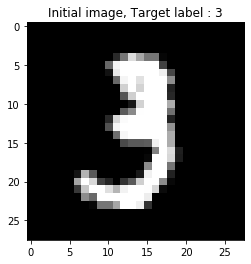

In [6]:
index = 10
print("Size of the input image : ",trainset[index][0].size())
plt.imshow(trainset[index][0].view(trainset[index][0].size()[1],trainset[index][0].size()[2]),cmap='gray')
plt.title("Initial image, Target label : "+str(trainset[index][1]))
plt.show()

##### Train and validation loaders

In [6]:
train_loader = DataLoader(trainset, args['batch_size'], shuffle=True, **kwargs)
# val_loader = DataLoader(valset, args['val_batch_size'], shuffle=True, **kwargs)

#### Add padding to obtain 32x32 images

In [7]:
from torchvision.datasets import VisionDataset
from albumentations import Resize, Compose
from torchvision import transforms

In [8]:
# check_black = [tup[0][0,0,0].item() for tup in trainset]+[tup[0][0,0,0].item() for tup in valset]
# assert len(check_black) == len(trainset) + len(valset)
# padding_val = list(set(check_black))[0]
padding_val = trainset[0][0][0][0][0]
resizing_val = 32

In [9]:
class MNISTPad(VisionDataset):
    '''Class to handle to MNIST Dataset (resized)'''
    
    def __init__(self, dataset, transform, transform_val):
        self.images = [tup[0] for tup in dataset]
        self.target = [tup[1] for tup in dataset]
        self.transform = transform
        self.transform_val = transform_val
        self.root = dataset
        
        # Check length of target and image match
        assert len(self.images) == len(self.target)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = self.target[index]
        img = self.images[index]
        if self.transform == "padding":
            img = F.pad(img, 
                        # utiliser l'étoile ? 
                        pad=(self.transform_val, self.transform_val, self.transform_val, self.transform_val),
                        mode='constant', value=padding_val)
        
        if self.transform == "resizing":
            #TODO : add the resizing option instead of padding 
            resizing_transform = Compose([
#                         transforms.ToPILImage(),
                        Resize(height = resizing_val, width = resizing_val, always_apply = True),
                        transforms.ToTensor(),
                        ])
            
        return img, target

In [10]:
trainset_pad = MNISTPad(trainset, "padding", 2)
trainset_pad

Dataset MNISTPad
    Number of datapoints: 60000
    Root location: Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [50]:
# valset_pad = MNISTPad(valset, "padding", 2)
# valset_pad

Dataset MNISTPad
    Number of datapoints: 10000
    Root location: Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/MNIST
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Size of the input image :  torch.Size([1, 32, 32])


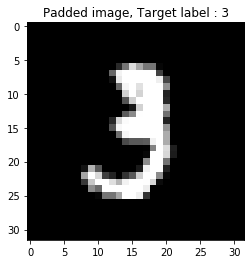

In [13]:
print("Size of the input image : ",trainset_pad[index][0].size())
plt.imshow(trainset_pad[index][0].view(trainset_pad[index][0].size()[1],trainset_pad[index][0].size()[2]),cmap='gray')
plt.title("Padded image, Target label : "+str(trainset_pad[index][1]))
plt.show()

##### Tests to include a resize option from albumentation instead of padding

In [ ]:
# import cv2
# # t = transforms.ToPILImage()
# # imgg = t(img[0,:,:,:])
# r = Resize(height = resizing_val, width = resizing_val, always_apply = True)
# # r(image=img)
# # r(image=cv2.cvtColor(cv2.UMat(np.float32(img[0,:,:,:])), cv2.COLOR_RGB2GRAY))
# r(image=cv2.cvtColor(cv2.UMat(np.float32(np.array(imgg))), cv2.COLOR_RGB2GRAY))


In [ ]:
# # Test for the resizing :
# resizing_transform = Compose([
# #                         transforms.ToPILImage(),
#                         Resize(height = resizing_val, width = resizing_val, always_apply = True),
#                         transforms.ToTensor(),
#                         ])
# resizing_transform(img[0,:,:,:])

##### Train and validation loaders

In [11]:
train_pad_loader = DataLoader(trainset_pad, args['batch_size'], shuffle=True, **kwargs)
# val_pad_loader = DataLoader(valset_pad, args['val_batch_size'], shuffle=True, **kwargs)

#### Create mixture of gaussians

In [55]:
def simulate_gaussian_mixture(cov_mixt_ratio, size_mixt, nb_modes = 8):
    '''Simulate gaussian mixture with nb_modes modes arranges around the unit circle
    Inputs :
    cov_mixt_ratio : the ratio by which the identity is divided when defining the covariance matrix
    size_mixt : the size of the vector for EACH gaussian
    nb_modes : the number of mixtures
    Outputs : 
    a numpy array of dimension (size_mixt*nb_modes , 2)
    '''
    val = np.arange(0,2*np.pi,np.pi/(nb_modes/2)) 
    x_val = np.cos(val)
    y_val = np.sin(val)
    mixture = []
    for i in range(len(val)):
        mixture.append(np.random.multivariate_normal(mean = [x_val[i],y_val[i]], cov = np.identity(2)/cov_mixt_ratio, size = size_mixt))

    mixture_vect = mixture[0]
    for i in range(1,len(val)):
        mixture_vect = np.concatenate([mixture_vect,mixture[i]])
    return mixture_vect

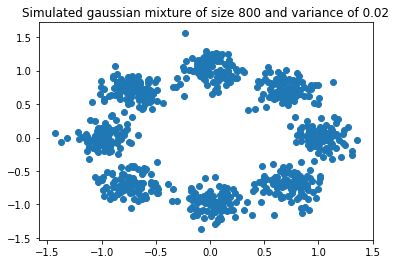

In [56]:
nb_modes = 8
size_mixt = 100
cov_mixt_ratio = 50 #aparent modes but not too separeted
mixture_vect = simulate_gaussian_mixture(cov_mixt_ratio, size_mixt, nb_modes)
plt.scatter(mixture_vect[:,0],mixture_vect[:,1])
plt.title("Simulated gaussian mixture of size "+str(nb_modes*size_mixt)+" and variance of "+str(1/cov_mixt_ratio))
plt.show()

The simulated gaussian mixtures need to be converted to an image. 

In [57]:
def array_to_img(array, img_size, return_normalized = False):
    """Function
    array : an array of dimension Kx2
    img_size : the dimension of the (square) image obtained
    return_normalized : also return the normalized array (for comparison)
    """
    mixture_norm = array+np.abs(np.min(array))
    mixture_norm = mixture_norm/(np.max(mixture_norm)-np.min(mixture_norm))
    round_array = np.round(mixture_norm*(img_size-1))
    gauss_img = np.zeros((img_size,img_size))
    for i in range(round_array.shape[0]):
        gauss_img[int(round_array[i,:][0]),int(round_array[i,:][1])] = 255
    if return_normalized == False :
        return gauss_img
    else :
        return gauss_img, mixture_norm

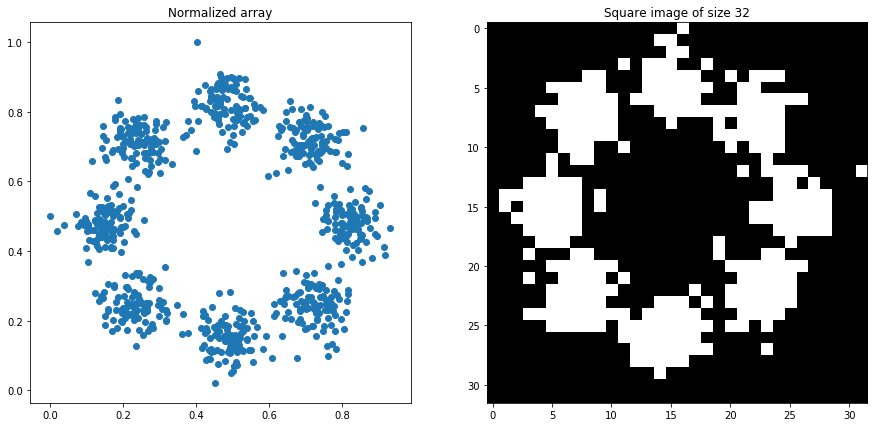

In [58]:
img_size = 32
gauss_img, mixture_norm = array_to_img(mixture_vect, img_size, return_normalized = True)

fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(mixture_norm[:,0],mixture_norm[:,1])
ax[0].set_title('Normalized array')
ax[1].imshow(gauss_img, cmap=plt.cm.gray)
ax[1].set_title('Square image of size '+str(img_size))
plt.show()

In [97]:
class GaussianMixtureDB(VisionDataset):
    '''Class with gaussian mixture data'''
    def __init__(self, dataset):
        self.images = dataset
        self.target = [0 for i in range(len(dataset))]
        self.root = "add/pickle/location"
        
        # Check length of target and image match
        assert len(self.images) == len(self.target)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = self.target[index]
        img = self.images[index]
            
        return img, target

In [98]:
size_GaussianMixtureDB = 20*args["batch_size"]
GaussianMixture_array = [simulate_gaussian_mixture(cov_mixt_ratio, size_mixt, nb_modes) for i in range(size_GaussianMixtureDB)]
GaussianMixture_imgs = [array_to_img(array, img_size, return_normalized = False) for array in GaussianMixture_array]
GaussianMixture_trainset = GaussianMixtureDB(GaussianMixture_imgs)
GaussianMixture_loader = DataLoader(GaussianMixture_trainset, args['batch_size'], shuffle=True, **kwargs)

In [99]:
GaussianMixture_trainset

Dataset GaussianMixtureDB
    Number of datapoints: 200
    Root location: add/pickle/location

In [64]:
try :
    del GaussianMixture_array
#     del GaussianMixture_imgs
except :
    print("deleted")

### Generator

#### Define Generator's architecture 
See Table 3 of [1]

As showed in the article for the CIFAR dataset : we use a $Uniform([-1,1])$ to generate noise

**Note** : We consider 3 dimensions for the 32x32 image, but we could have considered only one (greyscale image)

In [12]:
class _UpBlock_Generator(nn.Module):
    '''
    Class used in the Generator architecture
    Defines the 2xNN upsample, convolution and GLU for a given input size in_channels
    Input size : [bs, in_channels, n, n]
    Output size : [bs, in_channels/2, 2*n, 2*n]
    '''
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = 2*in_channels, out_channels = 2*in_channels, 
                              kernel_size = 5, padding=2, stride = 1)

    def forward(self, x: Tensor) -> Tensor:
        x =  F.interpolate(x, scale_factor=(2,2), mode = "nearest") 
        x = self.conv(x)
        x = F.glu(x,dim=1)
        return x

In [13]:
class Generator32x32(nn.Module):
    '''Class defining the Generator with the same architecture as used by Salimans. et al. for the CIFAR dataset
    Input : 
    input_dim : dimension of the noise z
    out_channels : number of colour channel (1 by default for greyscale images)
    
    '''
    def __init__(self, input_dim: int=100, out_channels = 1):
        super(Generator32x32, self).__init__()
#         self.linear = nn.Linear(in_features=input_dim, out_features=16384)
        self.linear = nn.Linear(in_features=input_dim, out_features=32768)
        self.up1 = _UpBlock_Generator(512) ###Pas bizarre de mettre un padding de 2?? 
        self.up2 = _UpBlock_Generator(256)
        self.up3 = _UpBlock_Generator(128)
        self.last_conv = nn.Conv2d(in_channels = 128, out_channels = out_channels, kernel_size = 5, padding=2, stride = 1)
    
    def generate_noise(self, bs, k=100):
        ''' Generate noise with dimension [bs, k] following a Uniform([-1,1])'''
        z = (torch.rand([bs, k], requires_grad = True)*2)-1
        return z
    
    def forward(self, x: Tensor):
        bs = x.size()[0]
        ## Linear layer and reshape
        x1 = self.linear(x)
        x1_a = F.glu(x1) # size 16384 
        x2 = x1_a.reshape(bs,1024,4,4) # size [bs, 1024, 4, 4] 
        ## Up blocks : upsample, convolution and GLU
        x3 =  self.up1(x2) # size [bs, 512, 8, 8]
        x4 =  self.up2(x3) # size [bs, 256, 16, 16]
        x5 =  self.up3(x4) # size [bs, 128, 32, 32]
        
        ## last convolution and activation
        x6 = self.last_conv(x5) # size [bs, 3, 32, 32]
        x7 = torch.tanh(x6) 
        out = x7 # size [bs, 3, 32, 32]
        return out 

#### Generate noise 

In [14]:
# Initialize random seed
torch.random.manual_seed(args['seed'])

# Define generator model
generate = Generator32x32()

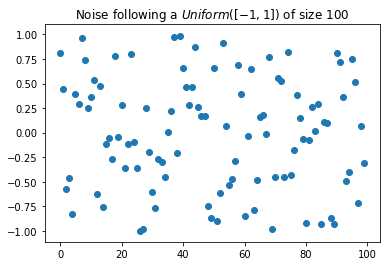

In [200]:
# Initialize random seed
torch.random.manual_seed(args['seed'])

# Generate noise of given batch size
k=100
# z = generate.generate_noise(bs = args["batch_size"], k = k)
z = generate.generate_noise(bs = 1, k = k)


# Scatter one example of noise
plt.scatter(range(k),z[0].detach())
plt.title("Noise following a $Uniform([-1,1])$ of size "+str(k))
plt.show()

In [201]:
# Test the output of the generator network
generator_output = generate(z)
print("Output size : ",generator_output.size())
print(generator_output)

Output size :  torch.Size([1, 1, 32, 32])
tensor([[[[-0.0040, -0.0034, -0.0034,  ..., -0.0038, -0.0041, -0.0039],
          [-0.0040, -0.0043, -0.0049,  ..., -0.0054, -0.0053, -0.0044],
          [-0.0040, -0.0047, -0.0043,  ..., -0.0040, -0.0048, -0.0037],
          ...,
          [-0.0045, -0.0056, -0.0045,  ..., -0.0005, -0.0018, -0.0018],
          [-0.0042, -0.0049, -0.0041,  ..., -0.0009, -0.0023, -0.0021],
          [-0.0046, -0.0045, -0.0028,  ..., -0.0009, -0.0021, -0.0019]]]],
       grad_fn=<TanhBackward>)


In [15]:
class NoiseDB(VisionDataset):
    '''Class with noise data'''
    def __init__(self, dataset):
        self.images = dataset
        self.target = [0 for i in range(len(dataset))]
        self.root = "add/pickle/location"
        
        # Check length of target and image match
        assert len(self.images) == len(self.target)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = self.target[index]
        img = self.images[index]
            
        return img, target

In [16]:
# Use the NoiseDB class to define a dataloader
Noise_trainset = NoiseDB(dataset=[generate.generate_noise(1, k=100) for i in range(len(trainset_pad))])
Noise_loader = DataLoader(Noise_trainset, args['batch_size'], shuffle=True, **kwargs)

Create a class that concatenates two datasets. When training the model, it enables to iterate both over the real images and the synthesized images (or the noise used to generate them) :

In [17]:
class ConcatenateDB(VisionDataset):
    '''Class to concatenate two dataset and return a tuple
    Inputs : datasets to concatenate 
    /!\ Assumptions :
    - several datasets are provided
    - both an image and a target are available (full of 0 if no target exists)
    - the datasets are of same size 
    Output : an iterable dataset, with a tuple of images and a tuple of targets provided at each iteration
    '''
    def __init__(self, *datasets):
        nb_datasets = len(datasets)
        len_datasets = len(datasets[0]) #assumes all datasets have the same length
        all_images = [[DB[i][0] for i in range(len_datasets)] for DB in datasets]
        all_targets = [[DB[i][1] for i in range(len_datasets)] for DB in datasets]
        
        self.images = list(zip(*all_images))
        self.targets = list(zip(*all_targets))
        self.root = "add/pickle/location"
        
        # Check length of target and image match
        assert len(self.images) == len(self.targets)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = self.targets[index]
        img = self.images[index]
            
        return img, target

In [18]:
# Trainset that concatenates the MNIST dataset and a dataset full of noise
conc_trainset = ConcatenateDB(trainset_pad,Noise_trainset)
# Data loader
conc_loader = DataLoader(conc_trainset, args['batch_size'], shuffle=True, **kwargs)

### Critic

#### Define critic architecture
See Table 4 of [1]

takes as input 3x32x32 or 1x32x32 ?

In [19]:
class _DownBlock_Critic(nn.Module):
    '''
    Class used in the Critic architecture
    Defines the convolution and CReLU 
    Input size : [bs, in_channels, n, n]
    Output size : [bs, in_channels*2, n/2, n/2]
    Inputs : 
    in_channels : int
    '''
    def __init__(self, in_channels):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = in_channels, 
                              kernel_size = 5, padding=2, stride = 2)

    def forward(self, x: Tensor) -> Tensor:
        x =  self.conv(x) 
        x = torch.cat((self.relu(x),self.relu(-x)),dim=1)
        return x

In [20]:
class Critic32x32(nn.Module):
    '''Class defining the critic with the same architecture as used by Salimans. et al. for the CIFAR dataset
    Input : 
    nb_channels : number of channels in the image (in particular, 1 or 3 ?)
    
    '''
    def __init__(self, nb_channels: int=1):
        super(Critic32x32, self).__init__()
        self.relu=nn.ReLU()
        self.init_conv = nn.Conv2d(in_channels = nb_channels, out_channels = 128, kernel_size = 5, padding = 2, stride = 1)
        self.down1 = _DownBlock_Critic(256)
        self.down2 = _DownBlock_Critic(512)
        self.down3 = _DownBlock_Critic(1024)
        
        
    def forward(self, x: Tensor):
        ## Initial convolution and CReLU
        x1 = self.init_conv(x) # size [bs, 128, 32, 32]
        x2 = torch.cat((self.relu(x1),self.relu(-x1)),dim=1) #size [bs, 256, 32, 32]
        ## Apply down block three times
        x3 = self.down1(x2) # size [bs, 512, 16, 16]
        x4 = self.down2(x3) # size [bs, 1024, 8, 8]
        x5 = self.down3(x4) # size [bs, 2048, 4, 4]
        ## Reshaping and l2 normalization
        bs = x5.size()[0]
        x5_reshape = x5.reshape(bs, 32768) # size [bs, 32768]uj
#         x5_norm = (torch.norm(x5_reshape, p=2, dim=1)+1e-10).view(bs,1) # size [1, bs]
        x5_norm = (torch.norm(x5_reshape, p=2, dim=1)).view(bs,1) # size [1, bs]
        out = x5_reshape/(x5_norm) # size [bs, 32768]
        return out

In [75]:
# Test with the first batch images from train_pad_loader
iterator = enumerate(train_pad_loader)
batch_idx, (imgs, targets) = next(iter(iterator))
critic = Critic32x32(nb_channels=1)
critic_output = critic(imgs)
print("Critic output size : ",critic_output.size())
print(critic_output)


Critic output size :  torch.Size([10, 32768])
tensor([[6.6080e-05, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.3207e-02,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.4654e-02,
         0.0000e+00],
        [0.0000e+00, 4.5279e-04, 0.0000e+00,  ..., 0.0000e+00, 1.5753e-02,
         6.0766e-03],
        ...,
        [1.7783e-03, 0.0000e+00, 2.2293e-04,  ..., 0.0000e+00, 1.9342e-03,
         1.0084e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.6771e-04, 0.0000e+00,
         7.1096e-04],
        [9.8800e-05, 1.9573e-03, 0.0000e+00,  ..., 0.0000e+00, 9.9821e-03,
         0.0000e+00]], grad_fn=<DivBackward0>)


#### Sinkhorn minibatch distance

Pytorch implementation : https://github.com/dfdazac/wassdistance/blob/master/layers.py


##### <span style="color:red"> Question : normalize C ? (cf TP : divide by max value) : Inside or outside of the function ?? 
##### <span style="color:red"> TODO : verify dimensions, verify the end
##### /!\ No need to propagate gradients for the sinkhorn distance : use detach or torch.no_grad ?? -> torch.no_grad to continue the propagation once the distance has been computed ? 

In [21]:
def sinkhorn_distance(C, epsilon=0.1, max_iters=100, a = "default", b = "default", detach = True):
    """Sinkhorn's distance
    Inputs : 
    C the cost matrix (a torch tensor) of size n x m
    epsilon : the regularization parameter of the Entropy-regularized Optimal Transport problem
    max_iters : number of iterations for the Sinkhorn's algorithm
    a : either "default" (then a will be initialized to a vector full of 1s) or a torch tensor
    b : either "default" (then a will be initialized to a vector full of 1s) or a torch tensor
    
    Output : the Sinkhorn distance between minibatch vectors X and Y
    """
#     n = C.shape[0]
    # Note : in our case we should have m = n (= K in the article's notations) if minibatches are of identical size
    n = C.size()[0]
    m = C.size()[1]
    
    ## Initialize a and b if necessary
    if a == "default":
#         a = np.ones(n)
        a = torch.ones([n], dtype=torch.float64)
    if b == "default":
#         b = np.ones(n)
        b = torch.ones([m], dtype=torch.float64)
    
    if detach == True :
        ## Stop gradient propagation during the computation of the distance
        with torch.no_grad():

            ## Compute the kernel matrix K
        #     K = np.exp(-C/epsilon)
            K = torch.exp(-C/epsilon)

            ## Alternate projections
        #     v = np.ones(b.shape[0])
            v = torch.ones([b.size()[0]])
            for _ in range(max_iters):
        #         u = a / K.dot(v)
        #         v = b / K.T.dot(u)
                u = a / torch.matmul(K.double(),v.double())
                v = b / torch.matmul(torch.transpose(K,0,1).double(),u.double())

            ## Compute the matching matrix
        #     M = np.diag(u).dot(K).dot(np.diag(v))
            M = torch.matmul(torch.matmul(torch.diag(u),K.double()),torch.diag(v))
            return torch.sum(M*C)
    else :
    ## Compute the kernel matrix K
    #     K = np.exp(-C/epsilon)
        K = torch.exp(-C/epsilon)

        ## Alternate projections
    #     v = np.ones(b.shape[0])
        v = torch.ones([b.size()[0]])
        for _ in range(max_iters):
    #         u = a / K.dot(v)
    #         v = b / K.T.dot(u)
            u = a / torch.matmul(K.double(),v.double())
            v = b / torch.matmul(torch.transpose(K,0,1).double(),u.double())

        ## Compute the matching matrix
    #     M = np.diag(u).dot(K).dot(np.diag(v))
        M = torch.matmul(torch.matmul(torch.diag(u),K.double()),torch.diag(v))
        return torch.sum(M*C)

In [77]:
C = torch.rand([10,20])
sinkhorn_distance(C)

tensor(3.3049, dtype=torch.float64)

#### Cosine distance
In order to compare our algorithm when the transportation cost is adversarially learned, we compare with the cosine distance. 

In [22]:
# # Define the cosine similarity for torch tensors with 2 dimensions (including batch size)
# cos_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-08)
# def cos_dist(x,y):
#     '''Cosine distance between torch tensors x and y'''
#     return 1-cos_similarity(x,y)

def cos_dist(X,Y):
    '''Cosine distance between 
    Inputs : torch tensors of size [bs,n]
    Output : torch tensor of size [bs, bs]
    '''
    X_norm = X / X.norm(dim=1)[:, None]
    Y_norm = Y / Y.norm(dim=1)[:, None]
    cos_dist = torch.mm(X_norm, Y_norm.transpose(0,1))
    return cos_dist

def loss_cos_dist(X, Xp, Y, Yp, detach = False):
    '''Compute the loss of the OTGAN when the cost function is the cosine distance (cf Appendix D)
    Inputs : 
    X and Xp minibatches of real data
    Y and Yp minibatches of synthesized data
    detach : a boolean, whether or not to propagate gradient through Sinkhorn's distance calculation
    '''
    
    loss = sinkhorn_distance(cos_dist(X,Y), detach=detach) 
    loss += sinkhorn_distance(cos_dist(X,Yp), detach=detach) 
    loss += sinkhorn_distance(cos_dist(Xp,Y), detach=detach)
    loss += sinkhorn_distance(cos_dist(Xp,Yp), detach=detach)
    loss -= 2*sinkhorn_distance(cos_dist(X,Xp), detach=detach)
    loss -= 2*sinkhorn_distance(cos_dist(Y,Yp), detach=detach)
    
    return loss

### Training -- preliminary tests

/!\

- initialization --> possible to initialize weights
- save both generator & critic's infos


#### Issue : 
- if detach == False : then we backpropagate the gradients (!= what the authors seem to do)
- if detach == True : error, no gradient exists so backward is not possible

In [23]:
all_loss_G = []
all_loss_C = []
all_synth_img = []
all_features_real = []
all_features_synth = []
    
def train(model_C, model_G, loader, optimizer_C, optimizer_G, args, epoch):
    print('Training epoch {:d}'.format(epoch))
    
    model_G.train()
    model_C.train()

    # /!\/!\To uncomment (defined outside for now do to memory issues)
#     all_loss_G = []
#     all_loss_C = []
#     all_synth_img = []
#     all_features_real = []
#     all_features_synth = []

    for batch_idx, ((img, noise), (target, _)) in loader:
        ## Sample two independent minibatches

        # Sample a first minibatch
        X = img.to(device)
        Z = noise.detach().to(device)

        # Take the next step of iterator to sample a second minibatch
        batch_idx, ((imgp, noisep),(targetp, _p)) = next(loader)
        Xp = imgp.to(device)
        Zp = noisep.detach().to(device)

        # Embed real images into feature space by applying critic
        out_X = model_C(X)
        out_Xp = model_C(Xp)
        all_features_real.append((out_X,out_Xp))

        # Generate synthesized image from noise
        Y = model_G(Z)
        Yp = model_G(Zp)
        all_synth_img.append((Y,Yp))

        # Embed synthesized images into the feature space by using the critic
        # Question : remove gradient coming from the generator part ?? --> cf .detach()
        out_Y = model_C(Y.detach())
        out_Yp = model_C(Yp.detach())
        all_features_synth.append((out_Y,out_Yp))

        # Generator's update
        loss_G = loss_cos_dist(out_X,out_Xp,out_Y,out_Yp, detach = False)
        loss_G.backward(retain_graph=True)
        optimizer_G.step()
        optimizer_G.zero_grad()
        all_loss_G.append(loss_G)

        # Critic update (take into account the fact that we sample two minibatches at each round)
        if batch_idx % (2*args["n_gen"]) == 0 :
            loss_C = -loss_G
            loss_C.backward()
            optimizer_C.step()
            optimizer_C.zero_grad()
            all_loss_C.append(loss_C)
    
    return {"loss_C": all_loss_C,
           "loss_G": all_loss_G,
           "all_synth_img": all_synth_img,
           "all_features_synth" : all_features_synth,
           "all_features_real" : all_features_real}

In [24]:
######### Initialize everything again
# Load critic
model_C = Critic32x32()
model_C = model_C.to(device)
optimizer_C = torch.optim.Adam(params = model_C.parameters(), lr=args["lr"], betas=(args["beta1"], args["beta2"]))

# Load generator
model_G = Generator32x32()
model_G = model_G.to(device)
optimizer_G = torch.optim.Adam(params = model_G.parameters(), lr=args["lr"], betas=(args["beta1"], args["beta2"]))

# Check have an even number of minibatches
assert len(conc_trainset) % 2 == 0

######### Define iterator
conc_iterator = enumerate(conc_loader)


######## Test training
train_result=[]
for epoch in range(args["epochs"]):
    train_result.append(train(model_C, model_G, conc_iterator, optimizer_C, optimizer_G, args, epoch))

Training epoch 0


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 104857600 bytes. Buy new RAM!


Plot synthesized images after initialization of the generator network. 

**TODO** : check if padding is a problem when training the model --> look at the border of synthesized images

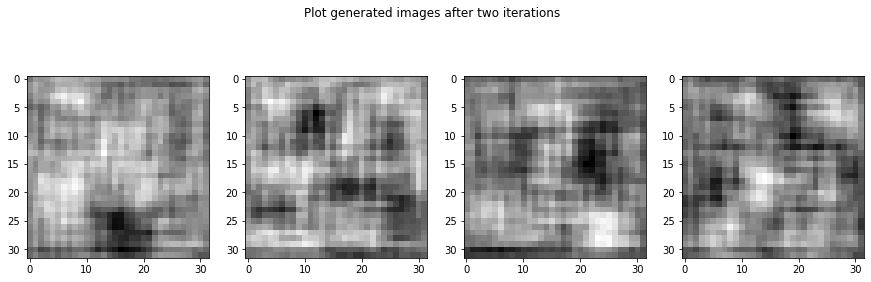

In [26]:
##### First epoch
# all_synth_img = train_result[0]["all_synth_img"]

fig, ax = plt.subplots(1,4, figsize=(15,7))
# First iteration (only take the first image of each minibatch)
ax[0].imshow(all_synth_img[0][0][0][0].detach(), cmap=plt.cm.gray)
ax[1].imshow(all_synth_img[0][1][0][0].detach(), cmap=plt.cm.gray)
# Second iteration
ax[2].imshow(all_synth_img[1][0][0][0].detach(), cmap=plt.cm.gray)
ax[3].imshow(all_synth_img[1][1][0][0].detach(), cmap=plt.cm.gray)
plt.suptitle("Plot generated images after two iterations")
plt.subplots_adjust(top=1.2)
plt.show()